- transfer learning에 augmentation을 더하는 것 에대한 의심을 품었지만 top freeze finetune은 더 그지같다는걸 확인하면서 pre-trained model on ImageNet을 사용한다는 거 자체가 내가 학습시킬 dataset에 전처리후 input의 분포가 pre-train된 이미지의 전처리 후 input의 분포가 상이해야 될듯한데 그 조건을 만족하기가 까다롭다고 생각하여 이번엔 애초에 __transfer learning 안함~__.
    - 이거!!! input 분포는 keras의 pretrained model on ImageNet 학습 코드를 찾아보고 mean,std normalize하는 부분 동일하게 적용시켜 보았는데 의미가 없었음
        (https://github.com/tensorflow/tensorflow/blob/2b96f3662bd776e277f86997659e61046b56c315/tensorflow/python/keras/applications/imagenet_utils.py#L158)
    - 아래 코드에선 normalize_and_resize_img함수가 이에 해당

<br>

- 쨋든 쌩 학습 ㄱㄱ

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import pickle

print('z')

z


## Cutmix

In [2]:
def get_clip_box(image_a, image_b, proba = 1.0):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)
    
    P = tf.cast( tf.random.uniform([],0,1)<=proba, tf.int32)
    
    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32) * P
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32) * P
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    return mixed_img

def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = a*label_a + (1-a)*label_b
    return mixed_label

def cutmix(image, label, prob = 0.666, batch_size=16, img_size=224, num_classes=120, proba = 1.0):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        xa, ya, xb, yb = get_clip_box(image_a, image_b, proba)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## MixUp

In [3]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels


## dataset 전처리

In [4]:
def normalize_and_resize_img_origin(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# # official code normalize (imagenet)
# def normalize_and_resize_img(image, label, mean=[125.3, 123.0, 113.9], std=[63.0, 62.1, 66.7]):
#     """Normalizes images: `uint8` -> `float32`."""
#     image = tf.image.resize(image, [224, 224])
#     R = tf.divide(tf.subtract(image[..., 0], mean[0]), std[0])
#     G = tf.divide(tf.subtract(image[..., 1], mean[1]), std[1])
#     B = tf.divide(tf.subtract(image[..., 2], mean[2]), std[2])
    
#     return tf.cast(tf.stack([R,G,B], axis=-1), tf.float32), label

In [5]:
def base_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])

    return image, label

- augment 는 이전과같이 baseline으로 적용

In [6]:
def onehot(image, label):
    num_classes = 120
    onehot_label = tf.one_hot(label, num_classes)
    return image, onehot_label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img_origin, 
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    if not is_test and  with_aug:
        ds = ds.map(
            base_augment,
            num_parallel_calls=2
        )
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    elif not with_cutmix and not with_mixup and is_test:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes

In [8]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)


(ds_train_base, ds_test_base) = tfds.load(
    'stanford_dogs',
    # split=['train[:40]', 'train[40:50]', 'train[50:60]'],
    split = ['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
)
ds_train_base = apply_normalize_on_dataset(ds_train_base, with_aug=False, with_cutmix=False, with_mixup=False)
ds_test_base = ds_test_base.map(normalize_and_resize_img_origin, 
        num_parallel_calls=2).batch(16).prefetch(tf.data.experimental.AUTOTUNE)



EPOCH = 30

## basemodel

In [9]:
# # augmentation 적용 할 모델 (bsseline)

# resnet50_baseline = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         input_shape=(224, 224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation = 'softmax')
# ])

In [10]:
# tf.random.set_seed(2020)
# resnet50_baseline.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
# )

# resnet50_base_hist = resnet50_baseline.fit(
#     ds_train_base, # augmentation 적용하지 않은 데이터셋 사용
#     # steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     # validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test_base,
#     verbose=1,
#     use_multiprocessing=True,
# )

# resnet50_baseline.save_weights('resnet50_baseline')
# with open('./notfinetune/resnet50_base_hist', 'wb') as file_pi:
#     pickle.dump(resnet50_base_hist.history, file_pi)

# resnet50_base_hist = pickle.load(open('./notfinetune/resnet50_base_hist', "rb"))

In [11]:
resnet50_base_hist = pickle.load(open('./notfinetune/resnet50_base_hist', "rb"))

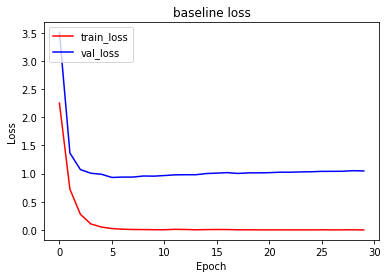

In [12]:
plt.plot(resnet50_base_hist['loss'], 'r')
plt.plot(resnet50_base_hist['val_loss'], 'b')
plt.title('baseline loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

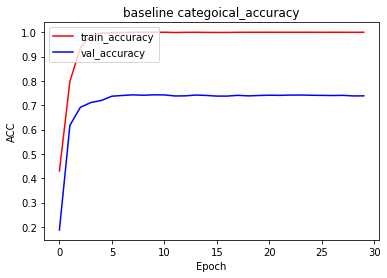

In [13]:
plt.plot(resnet50_base_hist['sparse_categorical_accuracy'], 'r')
plt.plot(resnet50_base_hist['val_sparse_categorical_accuracy'], 'b')
plt.title('baseline categoical_accuracy')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

## Cutmix model

In [14]:
# resnet50_cutmix = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         input_shape=(224, 224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation = 'softmax')
# ])

In [15]:
# resnet50_cutmix.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=False),
#     metrics=[tf.keras.metrics.CategoricalAccuracy()]
# )

# resnet50_cutmix_hist = resnet50_cutmix.fit(
#     ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
# )

# resnet50_cutmix.save_weights('resnet50_cutmix')
# with open('./notfinetune/resnet50_cutmix_hist', 'wb') as file_pi:
#     pickle.dump(resnet50_cutmix_hist.history, file_pi)


In [16]:
resnet50_cutmix_hist = pickle.load(open('./notfinetune/resnet50_cutmix_hist', "rb"))

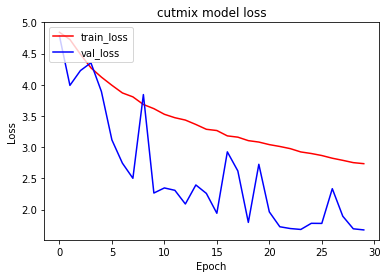

In [17]:
plt.plot(resnet50_cutmix_hist['loss'], 'r')
plt.plot(resnet50_cutmix_hist['val_loss'], 'b')
plt.title('cutmix model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

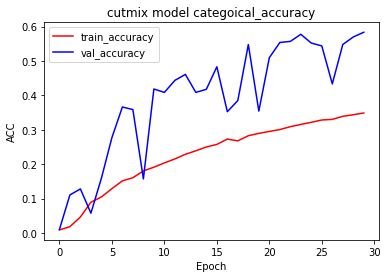

In [18]:
plt.plot(resnet50_cutmix_hist['categorical_accuracy'], 'r')
plt.plot(resnet50_cutmix_hist['val_categorical_accuracy'], 'b')
plt.title('cutmix model categoical_accuracy')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

- 일단 위 그래프를 보면 train loss (or acc)가 안정적으로 수렴하고있지만 val loss는 불안정하게 튀면서 수렴하고있고 또한 train data보다 val data가  더 낮은 loss를 보인다 -> transfer learning때와 비슷한 상황
<br><br>
- train loss가 val loss보다 높은것은 augmentation(cutmix)를 train data에만 적용시켰기에 그럴수 있다 생각.
    - 원래 test set에도 average 시켜줘야하는거 아닌가? ;;;
    - TTA는 나중에 시도해보자 ㅜㅜ
<br><br>
- val loss가 에폭마다 튀면서 수렴하는 이유는????
    - 뇌피셜 : __아마 val set의 크기가 train set크기만큼 되었으면 덜 튀는 것 처럼 보이지 않았을까??__
<br><br>

- (꿀팁) __Do not use too many augmentations in one sequence. You may simply create a totally new observation  that has nothing in common with your original training (or testing data)__

- (꿀팁2)  __Image data augmentation is typically only applied to the training dataset, and not to the validation or test dataset. This is different from data preparation such as image resizing and pixel scaling; they must be performed consistently across all datasets that interact with the model.__

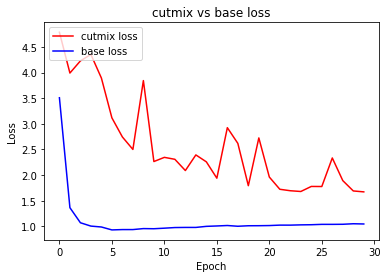

In [19]:
plt.plot(resnet50_cutmix_hist['val_loss'], 'r')
plt.plot(resnet50_base_hist['val_loss'], 'b')
plt.title('cutmix vs base loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['cutmix loss', 'base loss'], loc='upper left')
plt.show()

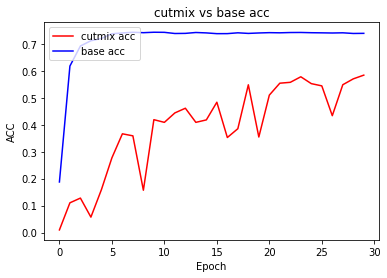

In [26]:
plt.plot(resnet50_cutmix_hist['val_categorical_accuracy'], 'r')
plt.plot(resnet50_base_hist['val_sparse_categorical_accuracy'], 'b')
plt.title('cutmix vs base acc')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['cutmix acc', 'base acc'], loc='upper left')
plt.show()

- 30에폭에서도 여전히 우상향이니 epoch늘려서 좀더 학습 시켜봐야하긴 할듯

- 논문에서도 ResNet-50을 ImageNet에 300에폭돌려서 top-1 error 2퍼 낮췄으니 (것도 250에폭 근처에서 base에비해 유의미하게 벌어짐);;
    - 저정도 에폭을 돌릴 여유가 읎음

## MixUp model

In [21]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [22]:
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

resnet50_mixup_hist = resnet50_mixup.fit(
    ds_train_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

resnet50_mixup.save_weights('ds_train_mixup')
with open('./notfinetune/resnet50_mixup_hist', 'wb') as file_pi:
    pickle.dump(resnet50_mixup_hist.history, file_pi)

resnet50_mixup_hist = pickle.load(open('./notfinetune/resnet50_mixup_hist', "rb"))

Train for 750 steps, validate for 536 steps
Epoch 1/30
750/750 [==============================] - 134s 178ms/step - loss: 4.5733 - categorical_accuracy: 0.0465 - val_loss: 4.9701 - val_categorical_accuracy: 0.0195
Epoch 2/30
750/750 [==============================] - 126s 168ms/step - loss: 3.7861 - categorical_accuracy: 0.1844 - val_loss: 3.2176 - val_categorical_accuracy: 0.2039
Epoch 3/30
750/750 [==============================] - 126s 169ms/step - loss: 3.3598 - categorical_accuracy: 0.3038 - val_loss: 4.7784 - val_categorical_accuracy: 0.0989
Epoch 4/30
750/750 [==============================] - 127s 169ms/step - loss: 3.0860 - categorical_accuracy: 0.3918 - val_loss: 2.9966 - val_categorical_accuracy: 0.2750
Epoch 5/30
750/750 [==============================] - 127s 169ms/step - loss: 2.8632 - categorical_accuracy: 0.4688 - val_loss: 2.7573 - val_categorical_accuracy: 0.3422
Epoch 6/30
750/750 [==============================] - 129s 172ms/step - loss: 2.6913 - categorical_accurac

In [23]:
resnet50_mixup_hist = pickle.load(open('./notfinetune/resnet50_mixup_hist', "rb"))

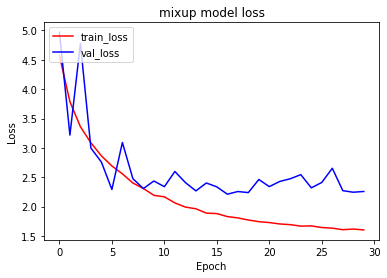

In [24]:
plt.plot(resnet50_mixup_hist['loss'], 'r')
plt.plot(resnet50_mixup_hist['val_loss'], 'b')
plt.title('mixup model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

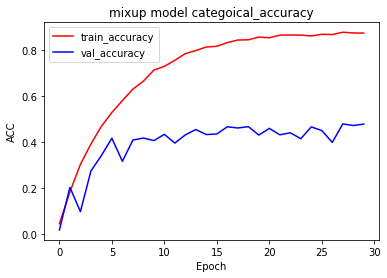

In [25]:
plt.plot(resnet50_mixup_hist['categorical_accuracy'], 'r')
plt.plot(resnet50_mixup_hist['val_categorical_accuracy'], 'b')
plt.title('mixup model categoical_accuracy')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

- 엥 mixup은 10~15epoch에서부터 학습이 진행되지 않는다
    - early stopping이나 걸어둘걸;;

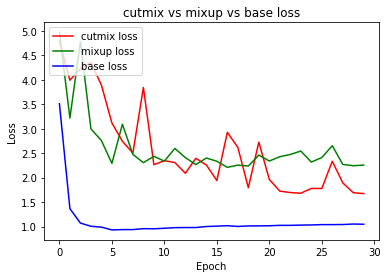

In [27]:
plt.plot(resnet50_cutmix_hist['val_loss'], 'r')
plt.plot(resnet50_mixup_hist['val_loss'], 'g')
plt.plot(resnet50_base_hist['val_loss'], 'b')
plt.title('cutmix vs mixup vs base loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['cutmix loss', 'mixup loss', 'base loss'], loc='upper left')
plt.show()

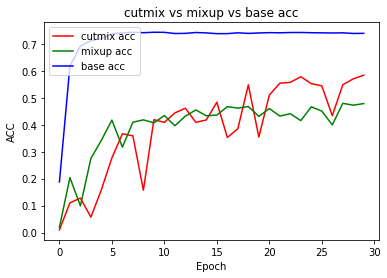

In [28]:
plt.plot(resnet50_cutmix_hist['val_categorical_accuracy'], 'r')
plt.plot(resnet50_mixup_hist['val_categorical_accuracy'], 'g')
plt.plot(resnet50_base_hist['val_sparse_categorical_accuracy'], 'b')
plt.title('cutmix vs mixup vs base acc')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['cutmix acc', 'mixup acc', 'base acc'], loc='upper left')
plt.show()

- 처음에 진행했던 imageNet pre-trained된 모델에 finetune한 결과랑 비교 ㄱㄱ

In [31]:
resnet50_finetune_baseline = pickle.load(open('./aug_history_and_weights/resnet50_aug_hist', "rb"))
resnet50_finetune_cutmix = pickle.load(open('./aug_history_and_weights/resnet50_cutmix_hist', "rb"))
resnet50_finetune_mixup = pickle.load(open('./aug_history_and_weights/resnet50_mixup_hist', "rb"))

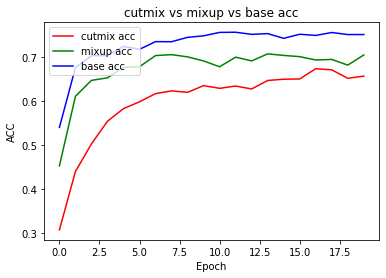

In [33]:
plt.plot(resnet50_finetune_cutmix['val_categorical_accuracy'], 'r')
plt.plot(resnet50_finetune_mixup['val_categorical_accuracy'], 'g')
plt.plot(resnet50_finetune_baseline['val_sparse_categorical_accuracy'], 'b')
plt.title('cutmix vs mixup vs base acc')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['cutmix acc', 'mixup acc', 'base acc'], loc='upper left')
plt.show()

## 이번 실험 결론

- ImageNet에 pre-trained된 모델에 finetune한 결과랑 쌩 학습의 차이점
    - 일단 finetune했을때보다 쌩학습의 val dataset acc가 불안정하게 학습됨 (cutmix, mixup)
        - 뇌피셜 : __아마 val set의 크기가 train set크기만큼 되었으면 덜 튀는 것 처럼 보이지 않았을까??__
            - 다른 dataset에 적용시켜보자
    - cutmix는 epoch을 늘려 좀더 수렴하게끔 해볼만함.
    - mixup은 finetune안하면 error훨씬 높고 epoch 늘린다고 좀더 수렴할것 같지 않음